# Introduction

The following is Baptiste Metge challenge's notebook. Thanks a lot for your time reviewing it.

I decided to go for the omniglot challenge since I am very interested in computer vision and it reminded me my master thesis, back at the university, on face recognition when only a single image of the person to recognise was provided.

Omniglot is a database of 50 alphabets hand-written characters images with 20 different images per letter.

The challenge : "Use background set of 30 alphabets for training and evaluate on set of 20 alphabets. Report one-shot classification (20-way) results."

As requested, I will describe my process steps to tackle this challenge.

What I usualy do first, is to have a look at the data. I therefore downloaded the data from the git repo suggested for sampling : https://github.com/brendenlake/omniglot and since its amount is relativly small, I had a look directly in my files system manager.

First thing to notice: data is well organised ( which is not always the case when you discover a new dataset). Training and testing data are in 2 separate folders. Then data is split by alphabet and then characters. Moreover, images are all squared, so resizing them all to the same dimensions should be easy.

Second step: online research about the Omniglot dataset : what is it ? Why was it made for ? etc. In order to better understand it. It was first intended to be a web design and translation service and it as been used in data science to do few-shot/one-shot/zero-shot learning.

Then, I did some online search to undertstand the meaning of "one-shot classification (20-way)". One-shot learning aims to learn information about object categories from one single training samples/images. 20 way means classifying our one shot query image/object within a support set of 20 images/objects.


Next step : what work has already been done by the data science community on OSL (One shot learning)? I've tried to gather main scientific papers on the topic. I had a quick look at the accuracy given on each papers, and their date of publication. I then picked up the recent papers having the top accuracies results and good comparative description of other methods. Having a look at the reputation of the publisher would make sense. I therefore selected for detailled  reading : Prototypical Network (PN) http://papers.nips.cc/paper/6996-prototypical-networks-for-few-shot-learning.pdf and Relational Network (RN) https://arxiv.org/pdf/1711.06025.pdf

Online I found two github torch implementation of the thoses papers made by their respectives writers, so probably reliable. Both had very similar results, RN was only a bit better. The main difference is that RN was learning a metric to calculate loss where PN was using a simple euclidian distance. I managed to run both code. However, PN was easier to understand to me, faster to run. Moreover, I managed to even boost it with my own implementation ( explain below). Therefore I decided to try to implement a prototypical network solution and try some "hacks" to improve it.

# set up, settings and import

This section install the required libs, upload the required data and does the set up.

In [4]:
# required lib installation
!pip install torch torchvision line_profiler pillow # you made need to restart runtime : "Runtime > restart runtime"

    100% |████████████████████████████████| 519.5MB 33kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x59762000 @  0x7f4aaaae02a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 21.2MB/s 
    100% |████████████████████████████████| 92kB 23.5MB/s 
  Running setup.py bdist_wheel for line-profiler ... - \ | / done
  Stored in directory: /root/.cache/pip/wheels/05/7d/9b/aafbe8d78dc2b2c644d2efd2f060ab3258143860142575193a
Successfully built line-profiler
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.


In [5]:
# clone the challenge repo for sampling 
!git clone https://github.com/brendenlake/omniglot.git

Cloning into 'omniglot'...
remote: Enumerating objects: 67, done.
remote: Total 67 (delta 0), reused 0 (delta 0), pack-reused 67
Unpacking objects: 100% (67/67), done.


** Folders arranging **

In [0]:
!mkdir data

In [0]:
!unzip -qq omniglot/python/images_evaluation.zip -d .

In [0]:
!unzip -qq omniglot/python/images_background.zip -d .

In [0]:
!mv images_background/* data

In [0]:
!mv images_evaluation/* data

In [11]:
# load my saved models and results. In case I do not want to retrain some models from scratch
!git clone https://github.com/bmetge/omniglot_20ways_1shot

Cloning into 'omniglot_20ways_1shot'...
remote: Enumerating objects: 63, done.
remote: Total 63 (delta 0), reused 0 (delta 0), pack-reused 63
Unpacking objects: 100% (63/63), done.


**Few generals settings**

*ATTENTION* : Please notice I used the learning rate settings of the paper implemantion from github. They does work quite well. A deeper study could be done for choosing them. However, picking up a good learning rate is a big topic by itself, I choosed to focus more on the one-shot 20 ways study, but it could be tackle for improvement.

In [0]:
root = "./data/"
background_path = "./omniglot/python/images_background.zip"
evaluation_path = "./omniglot/python/images_evaluation.zip"

# settings for the paper on PN
learning_rate=0.001
lr_scheduler_step=20  ##
lr_scheduler_gamma=0.5  ##

print_freq=1

device= "cuda:0" # put cpu here if you want to use your cpu instead

LOAD_MODEL = True

In [0]:
# libs importing
import torch
import torch.nn as nn
import torchvision
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from os.path import join as pj
import os
import zipfile
from tqdm import tqdm
import numpy as np
from itertools import chain
from sklearn.manifold import TSNE
from google.colab import files
from line_profiler import LineProfiler



%matplotlib inline
%load_ext line_profiler

In [0]:
# utils fonctions to save and load model or results that has been optain and store in the past to avoid retraining.
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)
        
def load_object(filename):
    try:
        if os.path.exists(filename):
            with open(filename, 'rb') as input:
                return pickle.load(input)
        else:
            return None
    except Exception as e:
        print("Error while loading object :" + str(e))
        return None
        

# How I speeded up the loss calculation fonction

As mentionned in my introduction, I managed to boost the calculation of the loss, by using broadcasting to calculate the euclidian distance. Below, we compare the speed of the original fonction "euclidean_dist" and my own fonction "ec". On the same test below the "euclidian_dist" tooks 2.64847 s to run where my "ec" fonction took  1.19781 s. You can tun the test yourself :  **It is more than 2 times faster.** most of the time. Considering we are calling it a tremendous amount of time while training, it is, I believe, a good finding.

In [0]:
# original
def euclidean_dist(x, y):
    '''
        Compute euclidean distance between two tensors
    '''
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    x = x.unsqueeze(1).expand(n, m, d) ## on copie m fois x
    y = y.unsqueeze(0).expand(n, m, d) ## on copie n fois y
    return torch.pow(x - y, 2).sum(2)  ## 

# boosted with broadcasting
def ec(x,y):
    xy = x.mm(y.t())  
    xnorm = (x*x).sum(1).unsqueeze(1)  
    ynorm = (y*y).sum(1).unsqueeze(0)
    return (xnorm + ynorm - 2*xy)

In [0]:
x = torch.from_numpy(np.random.rand(10000,1))
y = torch.from_numpy(np.random.rand(10000,1))

In [190]:
lp = LineProfiler()
lp_wrapper = lp(euclidean_dist)
lp_wrapper(x,y)
lp.print_stats()

Timer unit: 1e-06 s

Total time: 2.64847 s
File: <ipython-input-186-1d78da456e0d>
Function: euclidean_dist at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def euclidean_dist(x, y):
     2                                               '''
     3                                                   Compute euclidean distance between two tensors
     4                                               '''
     5         1         13.0     13.0      0.0      n = x.size(0)
     6         1          3.0      3.0      0.0      m = y.size(0)
     7         1          1.0      1.0      0.0      d = x.size(1)
     8         1        624.0    624.0      0.0      x = x.unsqueeze(1).expand(n, m, d) ## on copie m fois x
     9         1         23.0     23.0      0.0      y = y.unsqueeze(0).expand(n, m, d) ## on copie n fois y
    10         1    2647811.0 2647811.0    100.0      return torch.pow(x - y, 2).sum(2)  ## 



In [191]:
lp = LineProfiler()
lp_wrapper = lp(ec)
lp_wrapper(x,y)
lp.print_stats()

Timer unit: 1e-06 s

Total time: 1.19781 s
File: <ipython-input-186-1d78da456e0d>
Function: ec at line 13

Line #      Hits         Time  Per Hit   % Time  Line Contents
    13                                           def ec(x,y):
    14         1     289988.0 289988.0     24.2      xy = x.mm(y.t())  
    15         1        298.0    298.0      0.0      xnorm = (x*x).sum(1).unsqueeze(1)  
    16         1        206.0    206.0      0.0      ynorm = (y*y).sum(1).unsqueeze(0)
    17         1     907318.0 907318.0     75.7      return (xnorm + ynorm - 2*xy)



# Model Definition

Here is the Prototypical network definition. I did two changes from the reference paper:


1.   In the PN paper, the do some data augmentation of +90, -90 and 180 degrees on each image. I did some more light affine transformation to keep the augmented characters always on the same side. Since a "M" becomes a "W" when you flip it, I believe this was making more sense. 
2.   To augment the model capacity I used two different convolution block. "conv_block_shallow" is has describe in the paper conv-bn-relu-pool. And I tried using also a "conv_block_deep" which is a conv-bn-relu-conv-bn-relu-pool block.

Results are discussed below.



In [0]:
def conv_block_shallow(in_channels, out_channels):
    '''
    returns a block conv-bn-relu-pool
    '''
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

def conv_block_deep(in_channels, out_channels):
    '''
    returns a block conv-bn-relu-conv-bn-relu-pool
    '''
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        
        nn.MaxPool2d(2)
    )

class ProtoNet(nn.Module):
    '''
    Prototyical network as described in the reference paper,
    source: https://github.com/jakesnell/prototypical-networks/blob/f0c48808e496989d01db59f86d4449d7aee9ab0c/protonets/models/few_shot.py#L62-L84
    '''
    def __init__(self, x_dim=1, hid_dim=64, z_dim=64, conv_block=conv_block_deep):
        super(ProtoNet, self).__init__()
        self.encoder = nn.Sequential(
            conv_block(x_dim,   hid_dim),
            conv_block(hid_dim, hid_dim),
            conv_block(hid_dim, hid_dim),
            conv_block(hid_dim, z_dim),
        )

    def forward(self, x):
        x = self.encoder(x)
        return x.view(x.size(0), -1)
    
def get_model(model_path, conv_block=conv_block_deep):
    '''
    util fonction to upload a previously trained model if needed.
    '''
    if os.path.exists(model_path):
        try:
            model = ProtoNet(conv_block=conv_block).to(device)
            model.load_state_dict(torch.load(model_path))#, map_location={'cuda:0': 'cpu'}))   # uncomment when you work on cpu.
            return model
        except Exception as e:
            print("Error while loading model :" + str(e))
            return None
    else:
        return None


In [0]:
def train_split():
    '''
        Returns the alphabets folders name specify for training in the challenge.
    '''
    with zipfile.ZipFile(background_path) as f:
        x = set(map(lambda x:x.filename.split("/")[1], f.filelist))
        return list(filter(lambda x:len(x)>0, x))

def test_split():
    '''
        Returns the alphabets folders name specify for testing in the challenge.
    '''
    with zipfile.ZipFile(evaluation_path) as f:
        x = set(map(lambda x:x.filename.split("/")[1], f.filelist))
        return list(filter(lambda x:len(x)>0, x))

def load_data(classes):
    """
        Load the file data in memory 
        (without any operation on it to be able to perform different kind of transformation on it later if needed)
    """
    x, y, cur = [],[],0
    for cl in tqdm(classes):
        for ch in os.listdir(pj(root, cl)):
            base = pj(root, cl, ch)
            for im in filter(lambda x:x.endswith(".png"), os.listdir(base)):
                im = read_image(pj(base, im))
                x.append(im)
                y.append(cur)
            cur+=1
    y = torch.LongTensor(y).to(device)
    return x,y

def read_image(fp, size=(28,28)):
    '''
        reads an image
    '''
    im = Image.open(fp)
    im = im.convert("L")
    im = ImageOps.invert(im)
    return im.resize(size)
    return im


def transform_dataset(images, aff=lambda x:x):
    '''
        apply the transformation aff on the dataset ( used for data augmentation)
    '''
    x = [transform_image(im, aff) for im in images]
    return torch.cat(x).float().to(device)

def transform_image(im, aff):
    '''
        apply the transformation aff on im ( used for data augmentation)
    '''
    im = aff(im)
    im = im.resize((28,28))
    im = np.array(im)
    im = torch.from_numpy(im)
    return im.unsqueeze(0)

# Belows fonction are for setting up which data images to used on one batch testing case.
def get_batch_ids(n_class, n_way, k_shot, n_samp=20):
    cid  = np.random.choice(n_class, n_way, replace=False).repeat(k_shot) 
    offs = np.concatenate([np.random.choice(n_samp, k_shot, replace=False) for i in range(n_way)])
    return cid*n_samp + offs

def sample_set_ids(ids):
    return ids[::2], ids[1::2]
    
def index_bid(x, support, query):
    return x[support], x[query]

def sample_batch(x, n_class, n_way, k_shot, n_samp=20):
    bid = get_batch_ids(n_class, n_way, k_shot, n_samp)
    support, query = sample_set_ids(bid)
    return index_bid(x, support, query)



class OmniGlotDs():
    '''
        Omniglot dataset class. N-WAY default is 60 as it is specify in the paper to be better at training time.
    '''
    def __init__(self, classes, k_shot=5, n_way=60, n_samp=20, n_iter=1000, transform=None):
        self.x,self.y = load_data(classes)
        self.n_class = len(self.y.cpu().unique())
        self.n_iter = n_iter
        self.k_shot = k_shot
        self.n_way  = n_way
        self.n_samp = n_samp
        self.transform = transform if transform else lambda x:x
        self._generate_split()
        
    def _generate_split(self):
        self.X = transform_dataset(self.x, self.transform)
        
    def sample(self):
        return sample_batch(self.X, self.n_class, self.n_way, 
                            self.k_shot*2, self.n_samp)
    
    def __iter__(self):            
        for i in range(self.n_iter):
            yield self.sample()
            
    def __len__(self):
        return self.n_iter

In [0]:
def ec(x,y):
    xy = x.mm(y.t()) 
    xnorm = (x*x).sum(1).unsqueeze(1)
    ynorm = (y*y).sum(1).unsqueeze(0)
    return (xnorm + ynorm - 2*xy) 
 
def lossfunc(proto, query, lbl):
    dists = ec(query, proto)
    loss  = torch.nn.CrossEntropyLoss()(-dists, lbl)
    acc   = (dists.min(1)[1]==lbl).float().mean().item()
    return loss, acc

def test_model(model, ds):
    '''
        Test the model with the prototypical learning algorithm
    '''
    accuracy = []
    model.eval()
    n_way = ds.n_way
    k_shot = ds.k_shot
    lbl = torch.from_numpy(np.arange(n_way).repeat(k_shot)).to(device)
    for xim, yim in tqdm(ds):
        inp = torch.cat([xim,yim]).unsqueeze(1)
        out = model(inp)
        proto = out[:n_way*k_shot]
        proto = proto.view(ds.n_way, ds.k_shot,-1).mean(1)
        query = out[n_way*k_shot:]
        _, acc = lossfunc(proto, query, lbl)
        accuracy.append(acc)
    return accuracy

def get_loss_acc(model, ds):
    '''
        Returns loss and accuracy for model : model , used with ds dataset.
    '''
    accuracy = []
    losses = []
    model.eval()
    n_way = ds.n_way
    k_shot = ds.k_shot
    lbl = torch.from_numpy(np.arange(n_way).repeat(k_shot)).to(device)
    for xim, yim in tqdm(ds):
        inp = torch.cat([xim,yim]).unsqueeze(1)
        out = model(inp)
        proto = out[:n_way*k_shot]
        proto = proto.view(ds.n_way, ds.k_shot,-1).mean(1)
        query = out[n_way*k_shot:]
        loss, acc = lossfunc(proto, query, lbl)
        accuracy.append(acc)
        losses.append(loss)
    return losses, accuracy

def train_epoch(model, optim, ds):
    '''
        Train the model with the prototypical learning algorithm for one epoch.
    '''
    model.train()
    ds._generate_split()
    n_way = ds.n_way
    k_shot = ds.k_shot
    lbl = torch.from_numpy(np.arange(n_way).repeat(k_shot)).to(device)
    losses, accuracies = [],[]
    for xim, yim in tqdm(ds):
        inp = torch.cat([xim,yim]).unsqueeze(1)
        out = model(inp)
        
        proto = out[:n_way*k_shot]
        proto = proto.view(ds.n_way, ds.k_shot,-1).mean(1)
        query = out[n_way*k_shot:]
        loss, acc = lossfunc(proto, query, lbl)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        losses.append(loss.item())
        accuracies.append(acc)
    return losses, accuracies

def train_model(model, optim, ds_train, ds_test, lr_scheduler, nepochs=10, print_freq=2):
    '''
        Train the model with the prototypical learning algorithm on all epoch.
    '''
    losses, tr_acc, te_acc = [],[],[]
    for epoch in range(nepochs):
        loss, acc = train_epoch(model, optim, ds_train)
        losses.append(loss)
        tr_acc.append(acc)
        print('Training Avg Loss: {}, Avg Acc: {}'.format(np.mean(loss), np.mean(acc)))
        if epoch % print_freq==0:
            acc = test_model(model, ds_test)
            te_acc.append(acc)
            print('Test Accuracy: {}'.format(np.mean(acc)))
        lr_scheduler.step()
    return losses, tr_acc, te_acc

In [0]:
# loadling the classes splits
test_class = test_split()
train_class = train_split()

# params
nepochs = 50
nepochs = 2
print_freq=1
device="cuda:0" #device="cpu"  -> choose here

# Effect of data augmentation visualization

This section provide an hint on why using data augmentation at training time. Each time we run a batch we apply a random tranformation on it and you can see on the last cell that it looks like more images written by more persons of the same character. Data augmentation is a well known technique in data science.

In [0]:
test_class = test_split()

In [0]:
ds_test = OmniGlotDs(test_class, k_shot=1, n_iter=1000)

100%|██████████| 20/20 [00:03<00:00,  4.34it/s]


In [0]:
Aff = torchvision.transforms.RandomAffine(15, shear=25, scale=(.8,1.1), resample=Image.BILINEAR)

In [0]:
a = ds_test.x[0]

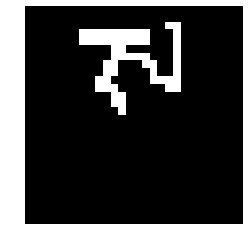

In [0]:
#plt.style.use("dark_background")
plt.axis('off')

plt.imshow(np.array(a), cmap="gray")

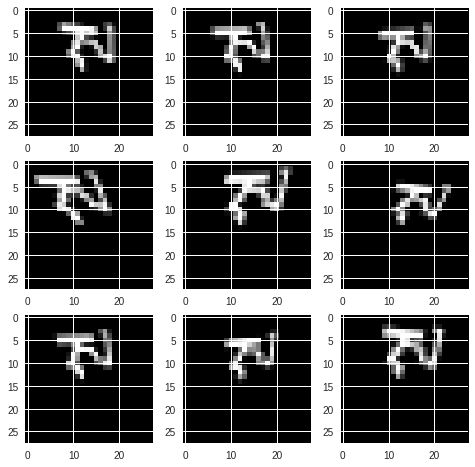

In [0]:
#plt.axis('off')

w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    img = Aff(a)
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.array(img), cmap='gray')
plt.show()

# Model validation

In this section we validate our model by testing it's accuracy. We test four cases:


1.   No  data augmentation with conv_block_shallow
2.   No data augmentation with conv_block_deep
3.   Data augmentation with conv_block_shallow
4.   Data augmentation with conv_block_deep

Plots of the results are below. We will see that option 4 works the best.





In [0]:
# no data augmentation 
no_augmentation  = lambda x:x
no_augmentation.__name__ = "no_augmentation"

# data augmentation
yes_augmentation = Aff = torchvision.transforms.RandomAffine(15, shear=25, scale=(.8,1.1))
yes_augmentation.__name__ = "yes_augmentation"

results = {}
models = {}

n_iter = 1000
nepochs = 50
print_freq = 1

for Aff in [no_augmentation, yes_augmentation]:
        # Testing the 2 conv blocks
        for conv_block in [conv_block_shallow, conv_block_deep]:
            key_path = Aff.__name__ + "_" + conv_block.__name__ + "_" + str(nepochs) + "_epochs"
            print("STATUS :   " + key_path)
            model_path_validation = "./omniglot_20ways_1shot/saved_models/model_validation_" + key_path
            result_pickle_name = "./omniglot_20ways_1shot/saved_results/result_validation_" + key_path + ".pkl"
            model_nways = get_model(model_path_validation,conv_block=conv_block)
            if model_nways:
                print('MODEL UPLOADED')
                models[(key_path)] = model_nways
                result = load_object(result_pickle_name)
                if result:
                    print('Results successfully retrived')
                    results[(key_path)] = result
                else:
                    print("Enable to load results !!!")
            else:
                print('MODEL NOT FOUND , creating one...')
                ds_train = OmniGlotDs(train_class, transform=Aff, k_shot=1, n_iter=n_iter)
                ds_test  = OmniGlotDs(test_class, k_shot=1, n_way=20, n_iter=n_iter)
                model = ProtoNet(conv_block=conv_block).to(device)
                
                # learning rate settings ( as in PN paper)
                optim = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
                lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optim,
                                                               gamma=lr_scheduler_gamma,
                                                               step_size=lr_scheduler_step)
                # training
                losses, tr_acc, te_acc = train_model(model, optim, ds_train, ds_test, lr_scheduler, nepochs=nepochs, print_freq=print_freq)
                results[(key_path)] = losses, tr_acc, te_acc
                models[(key_path)] = model
                
                # saving the model
                try:
                    print("Saving the model " + Aff.__name__ + conv_block.__name__)
                    torch.save(model.state_dict(), model_path_validation)
                    files.download(model_path_validation)
                except Exception as e:
                    print("Exception while saving model :" + str(e))
                    
                # saving the result
                try:
                    print("Saving the results " + Aff.__name__ + conv_block.__name__)
                    save_object(filename=result_pickle_name,obj=results[(key_path)])
                    files.download(result_pickle_name)
                except Exception as e:
                    print("Exception while saving results :" + str(e))


In [0]:
# prepare for plotting
res = []
models_ = []
for Aff in [no_augmentation, yes_augmentation]:
    for conv_block in [conv_block_shallow, conv_block_deep]:
        key_path = Aff.__name__ + "_" + conv_block.__name__ + "_" + str(nepochs) + "_epochs"
        res.append(results[(key_path)])        
        models_.append(models[(key_path)]) 

Final accuracy obtain: 91.01500095725059 / 100 % 



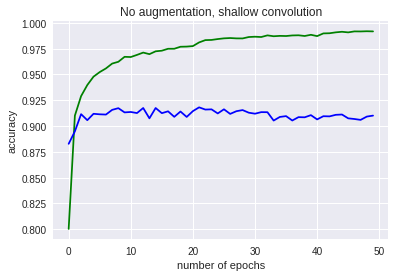

In [171]:
# No augmentation, shallow 
x = res[0]
loss = [np.mean(x_) for x_ in x[0]]
train = [np.mean(x_) for x_ in x[1]]
test = [np.mean(x_) for x_ in x[2]]
x_train = range(nepochs)
x_test = range(0,nepochs,print_freq)

plt.plot(x_train, train, color='green')
plt.plot(x_test, test, color='blue')
plt.title('No augmentation, shallow convolution')
plt.xlabel("number of epochs")
plt.ylabel("accuracy")

print("Final accuracy obtain: " + str(test[-1]*100) + " / 100 % \n")

First thing to notice, we reach more than 90% accuracy, so the model can be considered as working.

In green, we can see the training curve. In blue the testing curve. (we will keep this colors for all the following)

The training curve almost reach 100% accuracy at the end, while the testing curve stays around 91% . This clearly indicates a **overfitting** issue.


Final accuracy obtain: 91.8550010383129 / 100 % 



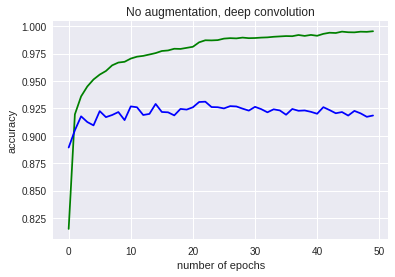

In [192]:
# No augmentation, Deep 
x = res[1]
loss = [np.mean(x_) for x_ in x[0]]
train = [np.mean(x_) for x_ in x[1]]
test = [np.mean(x_) for x_ in x[2]]
x_train = range(nepochs)
x_test = range(0,nepochs,print_freq)

plt.plot(x_train, train, color='green')
plt.plot(x_test, test, color='blue')
plt.title('No augmentation, deep convolution')
plt.xlabel("number of epochs")
plt.ylabel("accuracy")

print("Final accuracy obtain: " + str(test[-1]*100) + " / 100 % \n")

We also see an **overfitting** issue here. Though, our error went for 9% down to almost only 8%. **The model capacity to learn with conv_block_deep seems better !**

Final accuracy obtain: 92.92000084519387 / 100 % 



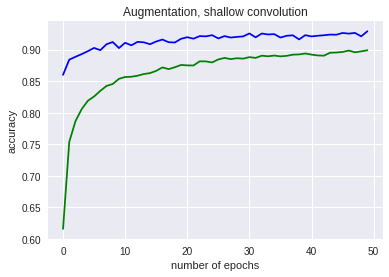

In [193]:
# Augmentation, shallow

x = res[2]
loss = [np.mean(x_) for x_ in x[0]]
train = [np.mean(x_) for x_ in x[1]]
test = [np.mean(x_) for x_ in x[2]]
x_train = range(nepochs)
x_test = range(0,nepochs,print_freq)

plt.plot(x_train, train, color='green')
plt.plot(x_test, test, color='blue')
plt.title('Augmentation, shallow convolution')
plt.xlabel("number of epochs")
plt.ylabel("accuracy")

print("Final accuracy obtain: " + str(test[-1]*100) + " / 100 % \n")

First thing to notice , the overfitting seems not reached yet on this graph. Training accuracy stays much below 100%. Moreover augmentation drops our error to almost only 7%. **ATTENTION: the testing curves is above the training curve, which can be surprising , but it is because , as stipulated above and in the paper, the training is done on 60 ways while the testing on 20 ways to get better results** Matching an object within 60 classes, is obviously more difficult than in 20, thus the above result. 

Final accuracy obtain: 93.15500075817108 / 100 % 



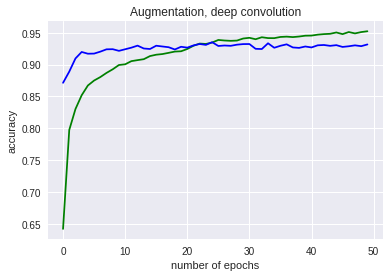

In [194]:
# Augmentation, deep ==> decent result !!

x = res[3]
loss = [np.mean(x_) for x_ in x[0]]
train = [np.mean(x_) for x_ in x[1]]
test = [np.mean(x_) for x_ in x[2]]
x_train = range(nepochs)
x_test = range(0,nepochs,print_freq)

plt.plot(x_train, train, color='green')
plt.plot(x_test, test, color='blue')
plt.title('Augmentation, deep convolution')
plt.xlabel("number of epochs")
plt.ylabel("accuracy")

print("Final accuracy obtain: " + str(test[-1]*100) + " / 100 % \n")

By combining Augmentation and deep convolution block , our error drops below 7%. This is the best result.

# Discussion

In the paper for prototypical network, they reach a 96 % accuracy where we reach 93%.

A potential explanation is that we are using different split. They use 1200 classes for training and 423 classes for testing. Our split use 964 classes for training and 659 for testing. Moreover, the 1200 classes they use in the paper are randomly selected from all the alphabet. In our split, we use separate alphabet for training and testing ! We can imagine that within a single alphabet there is similarities that can be learned at training in their case, but not in ours since our testing set is fully composed of unseen alphabet.

# Test on the challenge script runs

The script in the challenge  repo reach [an average error of 38.75%](https://www.kaggle.com/baptistemetge/omniglot-fellowai) on the small  set contain here : https://github.com/brendenlake/omniglot/blob/master/python/one-shot-classification/all_runs.zip


This section test our above model on this exact same set. 

In [0]:
# setting up the data from challenge script
!mkdir data_challenge

In [0]:
!unzip -qq ./omniglot/python/one-shot-classification/all_runs.zip -d data_challenge

In [29]:
# loading the above last model (session had crash in between and deadline is coming :/ )
LOAD_MODEL = True
challenge_model_path = "./omniglot_20ways_1shot/saved_models/model_validation_yes_augmentation_conv_block_deep_50_epochs"

if LOAD_MODEL:
    challenge_model = get_model(challenge_model_path)
    if challenge_model:
        print('MODEL UPLOADED CORRECTLY !')
    else:
        print('SORRY ! MODEL NOT FOUND. Please make sure your challenge_model_path is correct or train one with the above section')
else:
    try:
        challenge_model = model_optim
    except Exception as e:
        print("please make sure you have run the above section to get your optim or load one setting LOAD_MODEL=True")

MODEL UPLOADED CORRECTLY !


In [0]:
# Splits of the challenge  sampling
class ChallengeDataset(object):
    def __init__(self, root, nsamp):
        self.runs = []
        self.n_way = 20
        self.k_shot = nsamp
        self.base = root
        
        for run in os.listdir(root):
            fp = pj(root, run, "class_labels.txt")
            train, test = self._read_run(fp)
            self.runs.append([train, test])
            
    def __len__(self):
        return len(self.runs)
    
    def __iter__(self):
        for run in self.runs:
            yield run
            
    def _read_run(self, fp):
        with open(fp) as f:
            content = f.read().splitlines()
            pairs = [line.split() for line in content]
            test_files  = [pair[0] for pair in pairs]
            train_files = [pair[1] for pair in pairs]
        
        im = [read_image(pj(self.base, im)) for im in test_files]
        train = transform_dataset(im).view(-1,28,28)

        im = [read_image(pj(self.base, im)) for im in train_files]
        test = transform_dataset(im)
        
        return train, test
    
def read_image(fp, size=(28,28)):
    """
        read the image under fp filepath and resize it.
    """
    im = Image.open(fp)
    im = im.convert("L")
    im = ImageOps.invert(im)
    return im.resize(size)

    
def test_challenge(model, ds_test):
    '''
        Testing ont the challenge provided script same set
    '''
    accuracy = []
    model.eval()
    n_way = ds_test.n_way
    k_shot = ds_test.k_shot
    lbl = torch.from_numpy(np.arange(n_way)).to(device)
    print(lbl.size())
    for xim, yim in tqdm(ds_test):
        inp = torch.cat([xim,yim]).unsqueeze(1)
        out = model(inp)
        proto = out[:n_way*k_shot]
        proto = proto.view(ds_test.n_way, ds_test.k_shot,-1).mean(1)
        query = out[n_way*k_shot:]
        _, acc = lossfunc(proto, query, lbl)
        accuracy.append(acc)
    return accuracy

In [33]:
ds_challenge = ChallengeDataset("./data_challenge", 1)
challenge_acc = test_challenge(challenge_model, ds_challenge)
print("Accuracy in the challenge test = " + str(100*np.mean(challenge_acc)) + " % !")


100%|██████████| 20/20 [00:00<00:00, 169.93it/s]

torch.Size([20])
Accuracy in the challenge test = 89.50000137090683 % !


# Discussion

Provided script had 38.75 % and we managed to get 89.5%.

One could wonder, why above we reach 93% with the same model. An potential explanation is that the all_runs.zip contains only 20 folders providing each 20 query images and a support set. So we are running only 400 times the test, which might not be enough to get a proper averge of the accuracy.

# Going further

The following section explore some ways to go further in trying to improving the results.  Though, due to a lack of time before the deadline, it only shows and explain the ideas, but no official conclusion will be made from the result, as it would require to diving more deeply in the study and run more test.

## Test Time augmentation

Test time augmentation is a well known technique to improve results at testing time. It does the same as the data augmentation we did above but at the testing time. It means, we will generate N affine transformation on each of images at test time. Below we show a small test using our "best" model and with several value of N.

In [0]:
# Test time augmentation
def transform_dataset_multi(images, aff=lambda x:x, nsamp=5):
    x = [transform_image_multi(im, aff, nsamp) for im in images]
    return torch.cat(x).float().to(device)

def transform_image_multi(im, aff, nsamp):
    im = [transform_image(im, aff) for i in range(nsamp)]
    im = torch.cat(im)
    return im.unsqueeze(0)


def index_bid_multi(x, y, support, query):
    return x[support].view(-1, 28, 28), y[query].view(-1, 28, 28)

def sample_batch_multi(x, y, n_class, n_way, k_shot, n_samp=20):
    bid = get_batch_ids(n_class, n_way, k_shot, n_samp)
    support, query = sample_set_ids(bid)
    return index_bid_multi(x, y, support, query)

class OmniGlotDsMulti():
    def __init__(self, classes, k_shot=5, n_way=60, n_samp=20, n_trans=10, n_iter=100, 
                 query_transform=None, proto_transform=None):
        """ 
            Todo.
        """
        self.x,self.y = load_data(classes)
        self.n_class = len(self.y.cpu().unique())
        self.n_iter = n_iter
        self.k_shot = k_shot
        self.n_way  = n_way
        self.n_samp = n_samp
        self.n_trans= n_trans
        self.query_transform = query_transform if query_transform else lambda x:x
        self.proto_transform = proto_transform if proto_transform else lambda x:x
        self.generate_split()
        self.generate_query_split()
        
    def generate_query_split(self):
        self.queries = transform_dataset(self.x, self.query_transform)
        
    def generate_split(self):
        self.support = transform_dataset_multi(self.x, self.proto_transform, self.n_trans)
        
    def sample(self):
        return sample_batch_multi(self.support, self.queries,
                                  self.n_class, self.n_way, 
                                  self.k_shot*2, self.n_samp)
    
    def __iter__(self):            
        for i in range(self.n_iter):
            yield self.sample()
            
    def __len__(self):
        return self.n_iter

In [0]:
def test_multi(model, ds):
    '''
        Run the test with test time augmentation:
         -> dataset shoud be = OmniGlotDSMulti
    '''
    accuracy = []
    model.eval()
    n_way = ds.n_way
    k_shot = ds.n_trans
    lbl = torch.from_numpy(np.arange(n_way)).to(device)
    for xim, yim in tqdm(ds):
        inp = torch.cat([xim,yim]).unsqueeze(1)
        out = model(inp)
        proto = out[:n_way*k_shot]
        proto = proto.view(n_way, k_shot,-1).mean(1)
        query = out[n_way*k_shot:]
        _, acc = lossfunc(proto, query, lbl)
        accuracy.append(acc)
    return accuracy

In [0]:
Aff = torchvision.transforms.RandomAffine(15, shear=25, scale=(.8,1.1))
N_TRANS = [5, 10, 15, 20, 25, 30]

n_iter = 1000
print_freq=1

#MODEL TO USE
model_ntrans = models_[-1]  # HERE SELECT THE MODEL YOU WANNA USE
test_acc_trans = []

#loading train set
ds_train = OmniGlotDs(train_class, transform=Aff, k_shot=1, n_iter=n_iter)#

for NTRA in N_TRANS:
    
    #loading test set
    ds_test  = OmniGlotDsMulti(test_class,query_transform=None, proto_transform=Aff, k_shot=1, n_way=20, n_iter=n_iter,n_trans=NTRA)
    te_acc = test_multi(model_ntrans,ds_test)
    test_acc_trans.append(np.mean(te_acc))

Text(0,0.5,'acc')

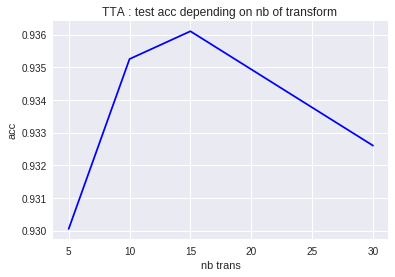

In [185]:
plt.plot(N_TRANS, test_acc_trans, color='blue')
plt.title("TTA : test acc depending on nb of transform ")
plt.xlabel('nb trans')
plt.ylabel('acc')

**discussion** 

We see that doing so we reach 93.6 % accuray with 15 transformations at test time (our last best result was 93.1% when without TTA). Though, we tested only a few N values, so we can't really conclude on which value for N transformation is the best, but hopefully I can provide more if we meet later for an interview.

## vizualising TTA effect

This section provides a visualization of what is happening with TTA.

In [0]:
colors = np.random.rand(20, 3)

def print_tsne(support, query, figsize=(10,10)):
    nclass = query.size(0)
    nsamp = int(support.size(0) / nclass)
    if "cuda" in device:
        data_points = torch.cat([support, query]).cpu().detach().numpy()
    else:
        data_points = torch.cat([support, query]).detach().numpy()
    points = TSNE(2).fit_transform(data_points)
    
    support_p = points[:nclass*nsamp]
    query_p = points[nclass*nsamp:]
    
    fig, axes = plt.subplots(1,1, figsize=figsize)
    for i in range(nclass):
        axes.scatter(support_p[i*nsamp:(i+1)*nsamp, 0], support_p[i*nsamp:(i+1)*nsamp,1], 
                     color=colors[i], marker="o", alpha=0.5)
        axes.scatter(query_p[i:(i+1),0], query_p[i:(i+1),1], color=colors[i], 
                     marker="v", linewidths=.5, edgecolors="k", alpha=1)

def plot_test_sample(model, ds):
    model.eval()
    n_way = ds.n_way
    k_shot = ds.n_trans
    
    for xim, yim in ds:
        break
        
    inp = torch.cat([xim,yim]).unsqueeze(1)
    out = model(inp)
    
    support = out[:n_way*k_shot]
    query = out[n_way*k_shot:]
    print_tsne(support, query)

In [0]:
# Avec data augmentation
n_trans = 10
ds_te = OmniGlotDsMulti(test_class,  proto_transform=Aff, 
                          k_shot=1, n_iter=1, 
                          n_way=20, n_trans=n_trans)

 TTA effect visualization with TSNE 



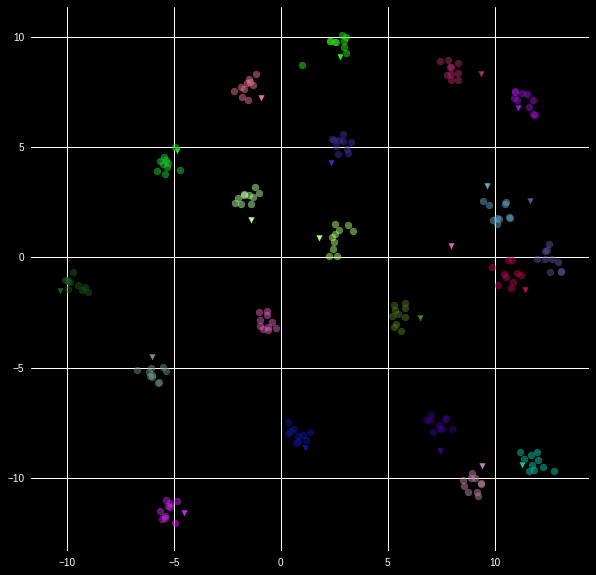

In [43]:
plt.style.use("dark_background")
print(' TTA effect visualization with TSNE \n')
plot_test_sample(challenge_model, ds_te)

**Explanation**

We used TNSE to project our data in 2 dimensions. Rounds of each color are the N generated images of a single support image at testing. The color corresponding triangle show the corresponding query image. Those clusters allows more chances for a query to be close to the support set it belongs to than if they was only one single support image per character (one round of each color)

## changing the N_WAYS at training time

**ACCORDING to the [paper](http://papers.nips.cc/paper/6996-prototypical-networks-for-few-shot-learning.pdf)** : *"We trained Prototypical Networks using Euclidean
distance in the 1-shot and 5-shot scenarios
with training episodes containing 60 classes
and 5 query points per class. We found that it
is advantageous to match the training-shot with
the test-shot, and to use more classes (higher
“way”) per training episode rather than fewer.""*


Can we verify this and what would happen with even higher values of N WAYS ? I used only 30 epochs to get my results. 

In [0]:
Aff = torchvision.transforms.RandomAffine(15, shear=25, scale=(.8,1.1))
N_WAYS = [5, 10, 20, 30, 45, 60, 80, 100, 120, 140]
results_nways = {}
models_nways = {}
nepochs = 30
n_iter = 1000
print_freq=1
LOAD_MODEL = True

#loading test set
ds_test  = OmniGlotDs(test_class, k_shot=1, n_way=20, n_iter=n_iter)

for NWAY in N_WAYS:
    model_path = "./omniglot_20ways_1shot/saved_models/model_" + str(NWAY) + "_nways_" + str(nepochs) + "_epochs"
    
    #loading train set
    ds_train = OmniGlotDs(train_class, transform=Aff, k_shot=1, n_iter=n_iter, n_way=NWAY)
    
    if LOAD_MODEL:
        model_nways = get_model(model_path)
        if model_nways:
            print('MODEL UPLOADED')
            losses, tr_acc = None, None # no relevant here 
            te_acc = test_model(model_nways, ds_test)
            results_nways[(NWAY)] = losses, tr_acc, te_acc
        else:
            print('MODEL NOT FOUND , creating one...')
            model_nways = ProtoNet(conv_block=conv_block_deep).to(device)

            # Adam and LR
            optim = torch.optim.Adam(params=model_nways.parameters(), lr=learning_rate)
            lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optim,
                                                           gamma=lr_scheduler_gamma,
                                                           step_size=lr_scheduler_step)
            # Training
            losses, tr_acc, te_acc = train_model(model_nways, optim, ds_train, ds_test, lr_scheduler, nepochs=nepochs, print_freq=print_freq)
            results_nways[(NWAY)] = losses, tr_acc, te_acc
            models_nways[(NWAY)] = model_nways
            # saving the model
            try:
                torch.save(model_nways.state_dict(), model_path)
                files.download(model_path)
            except Exception as e:
                print("Exception while saving model :" + str(e))

In [0]:
res_nways = []
for NWAY in N_WAYS:
    res_nways.append(results_nways[(NWAY)])

In [0]:
### TMP
res_nways = []
#N_WAYS = [5,10,20,30]
for NWAY in N_WAYS:
    res_nways.append(results_nways[(NWAY)])
    # saving the result
    try:
        result_pickle_name = "./omniglot_20ways_1shot/saved_results/result_" + str(NWAY) + "_nways_" + str(nepochs) + "_epochs"
        print("Saving the results " + result_pickle_name)
        save_object(filename=result_pickle_name,obj=results_nways[(NWAY)])
        files.download(result_pickle_name)
    except Exception as e:
        print("Exception while saving results :" + str(e))

In [0]:
!mkdir ./omniglot_20ways_1shot/saved_results

In [0]:
try:
    loss = [np.mean(x[0]) for x in res_nways]
    train = [np.mean(x[1]) for x in res_nways]
except Exception as e:
    pass
test = [np.mean(x[2]) for x in res_nways]

In [0]:
files.download("./omniglot_20ways_1shot/saved_models/model_140_nways_30_epochs")

Text(0.5,1,'test acc regarding nway at training')

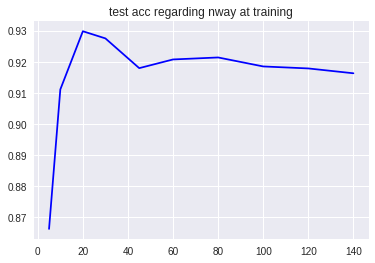

In [40]:
plt.plot(N_WAYS, test, color='blue')
plt.title("test acc regarding nway at training")

**Discussion**

When I first saw this result I was very surprise. The good thing is that it was confirming what was affirm in the paper : N ways at training influence the accuracy at testing time (with 20 ways).  However, my best result was for N = 20, while the paper had mention 60 was better than 20.
On one hand 20 could have make sence, since it was exactly the same condition as testing. But to verify my finding, I plotted below the testing accuracy for each N ways to see if it had already converge. We see that 45 ways, 60 ways , 80 ways were still rising ( so has not converge) and all of them at some point went above 93% accuracy, which the accuracy of the 20 ways after 30 epochs above. Therefore a longer test with more epochs should be run, but for the N ways used at training seems to have some infuence. Hopefull I can say more about it maybe if I hope we meet for the next step of recruitment process.

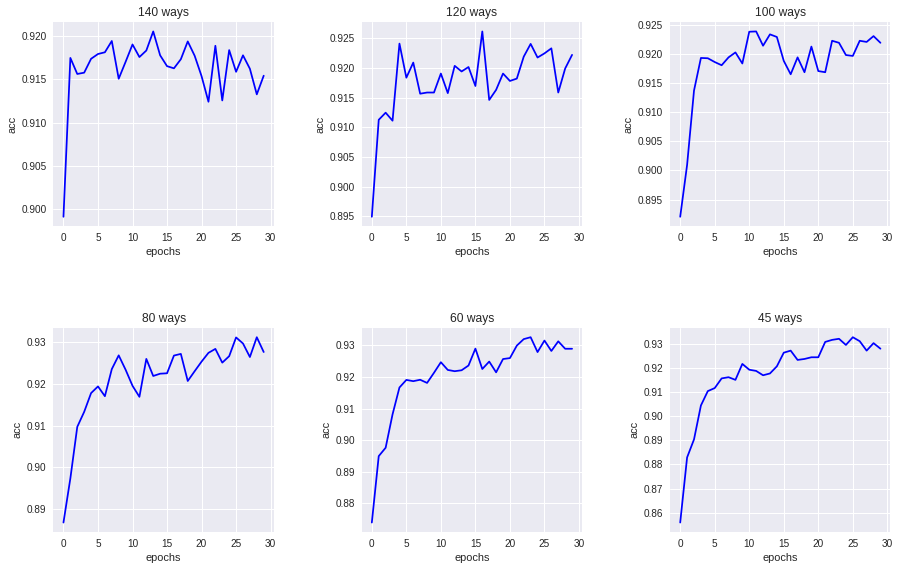

In [91]:
w=12
h=12
fig=plt.figure(figsize=(15, 15))
plt.subplots_adjust(hspace=0.5, wspace=0.4)

columns = 3
rows = 3
for i in range(1, 7):
    fig.add_subplot(rows, columns, i)
    x = res_nways[-i]
    loss = [np.mean(x_) for x_ in x[0]]
    train = [np.mean(x_) for x_ in x[1]]
    test = [np.mean(x_) for x_ in x[2]]
    x_train = range(nepochs)
    x_test = range(0,nepochs,print_freq)

    plt.plot(x_test, test, color='blue')
    plt.title(str(N_WAYS[-i]) + ' ways')
    plt.xlabel("epochs")
    plt.ylabel("acc")

test[-i]
plt.show()